In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

### EDA

- Load the data.
- Look at the `price` variable. Does it have a long tail?

In [2]:
s3_file_path = 's3://datasets/kaggle/dgomonov/new-york-city-airbnb-open-data/data.parquet'
df = pd.read_parquet(s3_file_path, storage_options={
    'profile': 'local',
    'client_kwargs': {
        'endpoint_url': 'http://192.168.46.220:9000'
    }
})
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,None,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


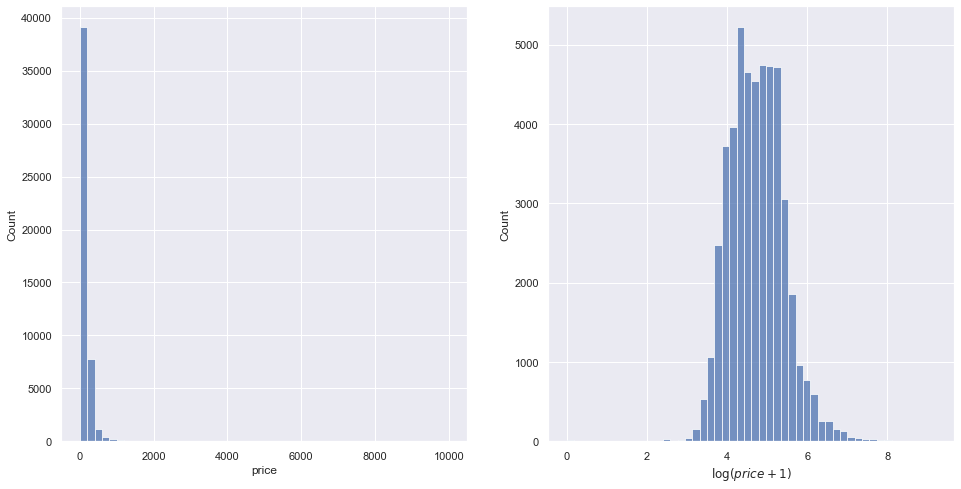

In [23]:
f, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(df.price, bins=50, ax=axs[0]);

sns.histplot(np.log1p(df.price), ax=axs[1], bins=50)
axs[1].set_xlabel('$\log(price + 1)$');

### Features

For the rest of the homework, you'll need to use only these columns:

- `'latitude'`,
- `'longitude'`,
- `'price'`,
- `'minimum_nights'`,
- `'number_of_reviews'`,
- `'reviews_per_month'`,
- `'calculated_host_listings_count'`,
- `'availability_365'`

In [4]:
features = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

### Question 1

Find a feature with missing values. How many missing values does it have?

In [5]:
df[features].isnull().sum()

latitude                              0
longitude                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
df['price'].isnull().sum()

0

### Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [7]:
df.minimum_nights.median()

3.0

Ans: 3.0

### Split the data

- Shuffle the initial dataset, use seed `42`.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Make sure that the target value ('price') is not in your dataframe.
- Apply the log transformation to the price variable using the `np.log1p()` function.

In [8]:
def split_train_test_set(X, y, test_ratio, random_state=42, shuffle=True):
    m = len(y)
    m_test = int(m * test_ratio)
    rnd = np.random.default_rng(random_state)
    seq = np.arange(m)
    if shuffle:
        rnd.shuffle(seq)
    X = X.iloc[seq]
    y = y[seq]
    X_test, y_test = X[:m_test], y[:m_test]
    X_train, y_train = X[m_test:], y[m_test:]
    return X_train, y_train, X_test, y_test

In [9]:
def normal_equation(X, y, reg=0):
    m = len(y)
    X = np.hstack([np.ones((m, 1)), X])
    XTX = X.T @ X
    XTX += np.eye(XTX.shape[0]) * reg
    XTX_inv = np.linalg.inv(XTX)
    theta = XTX_inv @ X.T @ y
    return theta[0], theta[1:]

In [10]:
def cal_rmse(yhat, y, roundto=2):
    error = yhat - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse), roundto)

In [11]:
X = df[features]
y = np.log1p(df['price'].values)

In [12]:
X_train, y_train, X_test, y_test = split_train_test_set(X, y, 0.4)
X_val, y_val, X_test, y_test = split_train_test_set(X_test, y_test, 0.5, shuffle=False)

### Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using `round(score, 2)`
- Which option gives better RMSE?

### Train with fillna(0)

In [13]:
X_train_w0 = X_train.fillna(0)

In [14]:
b, w = normal_equation(X_train_w0.values, y_train)

In [15]:
yhat = X_val.fillna(0) @ w + b
cal_rmse(yhat, y_val)

0.66

### Train with fillna(mean())

In [16]:
X_train_wm = X_train.copy()
reviews_per_month_mean = X_train['reviews_per_month'].mean()
X_train_wm['reviews_per_month'] = X_train['reviews_per_month'].fillna(reviews_per_month_mean)

In [17]:
b, w = normal_equation(X_train_wm, y_train)

In [18]:
yhat = X_val.fillna(reviews_per_month_mean) @ w + b
cal_rmse(yhat, y_val)

0.66

Ans: equally good

### Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [19]:
rs = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
rmse = []
for r in rs:
    b, w = normal_equation(X_train.fillna(0).values, y_train, r)
    yhat = X_val.fillna(0).values @ w + b
    rmse.append(cal_rmse(yhat, y_val))
idx = np.argmin(rmse)
rs[idx], rmse[idx]

(0, 0.66)

Ans: 0

In [24]:
seeds = range(10)
rmse = []
for seed in seeds:
    X_train, y_train, X_test, y_test = split_train_test_set(X, y, 0.4, random_state=seed)
    X_val, y_val, X_test, y_test = split_train_test_set(X_test, y_test, 0.5, shuffle=False)
    b, w = normal_equation(X_train.fillna(0).values, y_train)
    yhat = X_val.fillna(0).values @ w + b
    rmse.append(cal_rmse(yhat, y_val))
np.std(rmse)

0.007810249675906661

### Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with `r=0.001`.
- What's the RMSE on the test dataset?

In [21]:
X_train, y_train, X_test, y_test = split_train_test_set(X, y, 0.2, random_state=9)
b, w = normal_equation(X_train.fillna(0).values, y_train)
yhat = X_test.fillna(0).values @ w + b
cal_rmse(yhat, y_test)

0.64

Ans: 0.64